In [1]:
%matplotlib inline
import xlrd
import operator
import math
import re
import nltk
import scipy
import random
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm


# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


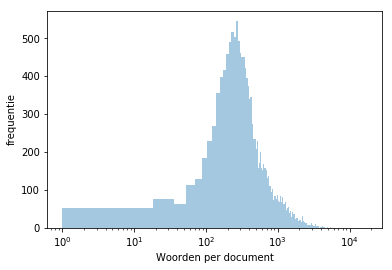

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


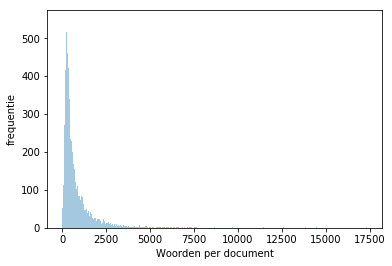

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


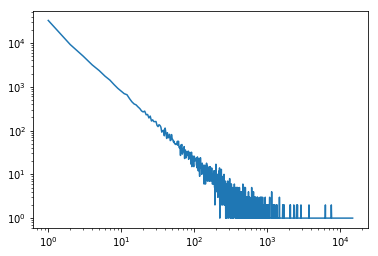

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.01      0.01      0.01       387
         CDA       0.12      0.13      0.12      1901
ChristenUnie       0.07      0.06      0.07      1068
         D66       0.13      0.13      0.13      1889
  GroenLinks       0.06      0.06      0.06      1068
         PVV       0.10      0.10      0.10      1700
        PvdA       0.13      0.13      0.13      1821
        PvdD       0.03      0.03      0.03       432
         SGP       0.05      0.05      0.05       655
          SP       0.15      0.15      0.15      2284
         VVD       0.11      0.11      0.11      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [ ]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [ ]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    if text_dict[name]:
         text = df.stemmed_text
    else:
        text = df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [11]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [12]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classifaction_report_csv(real,predicted,save):
    report = classification_report(real, predicted)
    report_data = []
    lines = report.split('\n')
    for line in lines[0:-1]:
        row = {}
        row_data = line.split('      ')
        if len(row_data)<5:
            continue
        row['Partij'] = row_data[-5].replace(" ","")
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1_score'] = float(row_data[-2])
        if row['Partij'] in predicted:
            row['Accuracy'] = np.nan
        else:
            row['Accuracy'] = accuracy_score(real, predicted)
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.reindex(["Partij","Precision","Recall","F1_score","Accuracy","Documenten"], axis=1).set_index('Partij')
    as_list = df.index.tolist()
    print(as_list)
    idx = as_list.index('avg/total')
    as_list[idx] = 'Totaal'
    df.index = as_list
    return df

In [13]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

In [14]:
def traintest3(pipe, text, data, save=False):
    train, test = train_test_split(data, test_size=0.2)
    pipe.fit(train["text"], train.party)
    predicted = pipe.predict(test["text"])
    report = classifaction_report_csv(test.party, predicted,False)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    return pipe, cnf_matrix, report, accuracy
    

def traintest(file, data, save=False, params=None, stemmed="stemmed_text",normal="normal_text"):
    n=5
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    if stem:
        pipe, cnf_matrix, report, accuracy = traintest3(base_pipe, stemmed, data, save=False)
    else:
        pipe, cnf_matrix, report, accuracy = traintest3(base_pipe, normal, data, save=False)
    for x in tqdm(range(n-1)):
        if stem:
            _, cnf_matrix2, report2, accuracy2 = traintest3(base_pipe, stemmed, data, save=False)
        else:
            _, cnf_matrix2, report2, accuracy2 = traintest3(base_pipe, normal, data, save=False)
        cnf_matrix = np.add(cnf_matrix,cnf_matrix2)
        report = report.add(report2, fill_value=0)
        accuracy += accuracy2
    accuracy /=n
    cnf_matrix = np.divide(cnf_matrix,n)
    report /=n
    report=report.round(2).fillna('-').round({'Documenten':0})
    print(report)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipe

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 25%|█████████████████████                                                               | 1/4 [01:13<03:40, 73.62s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 50%|██████████████████████████████████████████                                          | 2/4 [02:27<02:27, 73.61s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:41<01:13, 73.86s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:55<00:00, 73.93s/it]


              Precision  Recall  F1_score Accuracy  Documenten
50PLUS             0.97    0.85      0.91        -        71.4
CDA                0.80    0.79      0.80        -       379.6
ChristenUnie       0.83    0.76      0.79        -       215.4
D66                0.78    0.75      0.76        -       381.8
GroenLinks         0.89    0.73      0.80        -       209.2
PVV                0.82    0.88      0.85        -       345.0
PvdA               0.72    0.71      0.71        -       377.4
PvdD               0.86    0.87      0.86        -        81.2
SGP                0.87    0.84      0.86        -       134.8
SP                 0.73    0.85      0.78        -       453.2
VVD                0.77    0.73      0.75        -       331.0
Totaal             0.79    0.79      0.79     0.79      2980.0


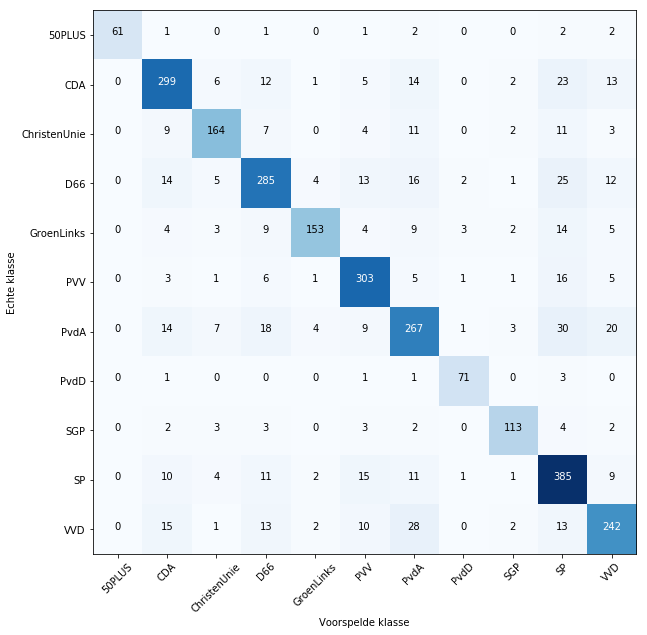

In [15]:
pipe = traintest('Scores.xlsx', df ,save="confusionmatrix")

In [16]:
def mostimportantwords(pipe, countdf, filename=None):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-100:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    if filename!=None:
        with open("Verslag/Tables/%s1.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,:5].head(10).to_latex(index=False))
        with open("Verslag/Tables/%s2.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,5:].head(10).to_latex(index=False))
        top_words.to_excel("%s.xlsx" %filename)
        
    return top_words.head(10)

In [17]:
mostimportantwords(pipe, countdf, filename='MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,het lid ouwehand,sgp,sp,de vvd
1,lid krol naar,het cda,christenunie,leden van veldhoven,lid van tongeren,de pvv,pvda,lid ouwehand naar,de sgp,de sp,vvd
2,het lid krol,de cda,lid dik,mijn fractie,tongeren,islamitische,van de arbeid,lid ouwehand,sgp fractie,sp fractie,de vvd fractie
3,lid krol,cda fractie,lid dik faber,van veldhoven,van tongeren,miljard,de arbeid,ouwehand,de sgp fractie,de sp fractie,vvd fractie
4,krol naar mij,de cda fractie,het lid dik,veldhoven,leden van tongeren,klever,de partij van,dieren,leden dijkgraaf,lid van gerven,de vvd is
5,krol naar,het lid omtzigt,dik faber,lid van veldhoven,lid voortman naar,nederland,partij van de,ouwehand naar mij,de leden dijkgraaf,smaling,vvd is
6,krol,lid omtzigt,faber,lid van meenen,lid voortman,graaf,partij van,ouwehand naar,leden van der,het lid smaling,voor de vvd
7,van 50plus,lid omtzigt naar,dik,het lid van,het lid voortman,pvv fractie,pvda fractie,de dieren,mevrouw de voorzitter,lid smaling,wat de vvd
8,ouderen,omtzigt naar mij,leden dik faber,meenen,voortman,de pvv fractie,arbeid,voor de dieren,mevrouw de,lid smaling naar,vvd betreft
9,gepensioneerden,omtzigt naar,leden dik,van meenen,tongeren naar mij,graus,de pvda fractie,thieme,leden bisschop,gerven,de vvd betreft


# Without Names

In [18]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
del temp
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 25%|█████████████████████                                                               | 1/4 [01:13<03:40, 73.61s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 50%|██████████████████████████████████████████                                          | 2/4 [02:27<02:27, 73.76s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [03:41<01:13, 73.80s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:55<00:00, 73.92s/it]


              Precision  Recall  F1_score Accuracy  Documenten
50PLUS             0.84    0.46      0.59        -        83.2
CDA                0.54    0.54      0.54        -       395.2
ChristenUnie       0.59    0.50      0.54        -       215.0
D66                0.54    0.52      0.52        -       379.2
GroenLinks         0.73    0.36      0.48        -       216.8
PVV                0.59    0.82      0.68        -       337.2
PvdA               0.52    0.45      0.48        -       365.2
PvdD               0.70    0.70      0.70        -        87.8
SGP                0.78    0.72      0.75        -       135.8
SP                 0.54    0.67      0.59        -       450.2
VVD                0.52    0.51      0.51        -       314.4
Totaal             0.58    0.57      0.56     0.57      2980.0


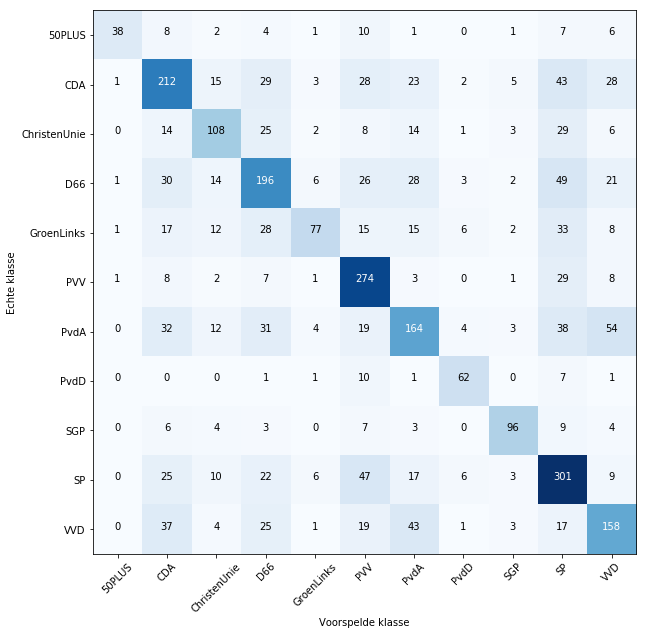

In [19]:
pipe = traintest('Scores.xlsx', df, save="withoutnames")

In [20]:
mostimportantwords(pipe, countdf, filename='MostImportantWordsWithoutNames', stemmed='stemmed_withoutnames', normal='normal_withoutnames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerden,PARTIJ fractie,dementie,mijn fractie,zou,islamitische,en,dieren,mevrouw de voorzitter,zegt,PARTIJ
1,ouderen,inwoners,gezinnen,mijn,kamer hierover te,miljard,jongeren,natuur,mevrouw de,mening dat,volgens mij
2,plussers,PARTIJ,inderdaad,natuurlijk,schone energie,nederland,samen,aarde,punt,mensen,regelgeving
3,50 plussers,regering,de eurozone,fractie,vluchtelingen,natuurlijk,wij,de aarde,beantwoording,van mening dat,aangegeven
4,50,hier,eurozone,buitengewoon,in elk geval,islam,tevens,milieu,voor de beantwoording,huurders,speelveld
5,koopkrachtontwikkeling,de regering,zullen,belangrijk,elk geval,brussel,vragen,industrie,bewindslieden,de bevolking,PARTIJ fractie
6,oudere,fractie,ik hoop,het kabinet,hierover te informeren,de islam,mijn partij,constaterende dat,de beantwoording,armoede,ao
7,werkenden,gewoon,onder,vandaag,in elk,asielzoekers,mening,constaterende,wel,bestuurders,aruba
8,aow,echt,mensenhandel,kabinet,schone,dit kabinet,de regering tevens,de bio,je,bezuinigingen,volgens
9,fractie van PARTIJ,een aantal,hoop,minister,regering om,al,regering tevens,burgers,maar,van mening,essentieel


# Only Names

In [21]:
df["names"] = df.text.apply(lambda x: re.findall(partijnamen, x)+re.findall(kamerlidnamen, x))
df["names"] = df.names.apply(lambda x: ' '.join([y.replace(" ", "") for y in x]).lower())
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text,names
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,devvd depvda vvd depvv rutte rutte rutte samso...,mevrouw de voorzitter dit kabinet heeft ons mo...,"[de VVD, de PvdA, VVD, de PVV, Rutte, Rutte, R..."
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,samsom rutte rutte samsom rutte samsom,voorzitter vorige week plaatsten werkgevers we...,"[Samsom, Rutte, Rutte, Samsom, Rutte, Samsom]"
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,d66 pvda d66 d66 rutte samsom,voorzitter twee maanden geleden kreeg dit kabi...,"[D66, PvdA, D66, D66, Rutte, Samsom]"
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,decda hetcda hetcda hetcda hetcda pechtold sam...,voorzitter alleen al in de eerste drie maanden...,"[de CDA, het CDA, het CDA, het CDA, het CDA, P..."
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,vvd pvda pvda devvd departijvandearbeid samsom...,voorzitter we zijn eruit eerst ontdekte de min...,"[VVD, PvdA, PvdA, De VVD, de Partij van de Arb..."


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 25%|█████████████████████                                                               | 1/4 [00:08<00:25,  8.59s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 50%|██████████████████████████████████████████                                          | 2/4 [00:17<00:17,  8.61s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:25<00:08,  8.62s/it]

['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:34<00:00,  8.62s/it]


              Precision  Recall  F1_score Accuracy  Documenten
50PLUS             0.63    0.51      0.56        -        68.2
CDA                0.59    0.40      0.46        -       389.8
ChristenUnie       0.58    0.46      0.50        -       219.2
D66                0.53    0.41      0.45        -       385.8
GroenLinks         0.57    0.38      0.45        -       225.4
PVV                0.59    0.78      0.67        -       338.6
PvdA               0.43    0.41      0.42        -       361.2
PvdD               0.60    0.68      0.64        -        83.8
SGP                0.55    0.75      0.63        -       129.8
SP                 0.48    0.66      0.55        -       441.4
VVD                0.49    0.46      0.46        -       336.8
Totaal             0.53    0.52      0.51     0.52      2980.0


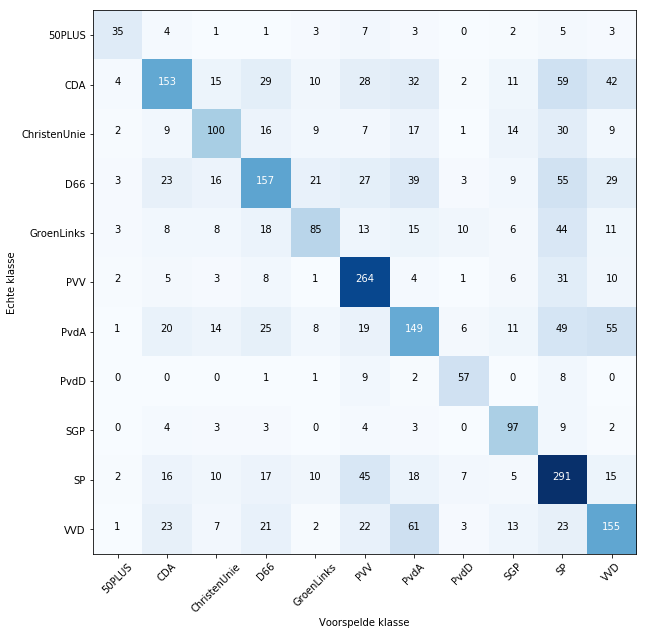

In [22]:
pipe = traintest('Scores.xlsx', df, save = "onlynames", params= {'vect__ngram_range':(1,1)}, stemmed='names', normal='names')

In [23]:
mostimportantwords(pipe, countdf, filename='onlynames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerden,inwoners,eurozone,mijn,banenplan,islamitische,en,constaterende,bewindslieden,mening,speelveld
1,plussers,regering,gezinnen,buitengewoon,schone,natuurlijk,circulaire,aarde,aandacht,zegt,essentieel
2,oudere,diverse,inderdaad,natuurlijk,zou,al,allen,klimaatverandering,beantwoording,huurders,aangegeven
3,koopkrachtontwikkeling,hier,ingezetenencriterium,belangrijk,belastingontwijking,islam,tevens,teelt,terrein,bevolking,wellicht
4,overwegende,net,constateer,kabinet,elk,lid,gezamenlijk,milieu,allereerst,segregatie,aruba
5,ouderen,bbl,rechtsstaat,kansen,verhuur,belastingbetaler,mening,bio,benadering,voorstellen,overwegende
6,50,zorginstellingen,dementie,vandaag,sekswerkers,nederland,rapporteren,kabinet,vervolg,regelen,PARTIJ
7,ouderenwerkloosheid,PARTIJ,steunpakket,daarom,vergroening,brussel,anders,industrie,wijze,regering,regelgeving
8,name,antwoord,keuze,advies,informeren,miljarden,daarbij,burgers,wettelijke,jsf,ao
9,werkenden,middeninkomens,hoop,belastinghervorming,mensenrechten,asielzoekers,vragen,dierenwelzijn,voren,bureaucratie,volgens


# Confusion matrix analyse

In [24]:
def traintest2(file, data, save=False):
    train, test = data
    pipe, stem = getbestpipe(file)
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)

    return pipe, oppositie, regering, mix, ggg

In [25]:
o = []
m = []
r = []
g = {}
for i in tqdm(range(10)):
    pipe, oppositie, regering, mix, ggg=traintest2('Scores.xlsx', train_test_split(df, test_size=0.2))
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:43<00:00, 76.30s/it]


(0.7904602915433744, 5.152345244202632e-23)

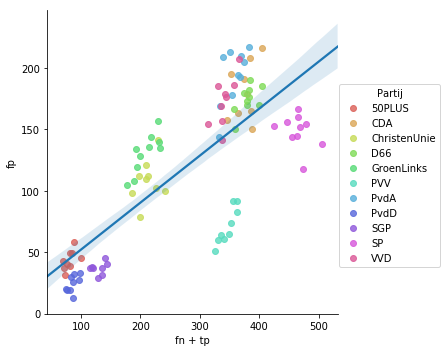

In [26]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name='fn + tp')
values = pd.Series(values,name='fp')
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='fn + tp', y='fp', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean: 0.41762955897638115
NormaltestResult(statistic=365.92948782938646, pvalue=3.462751571248647e-80)


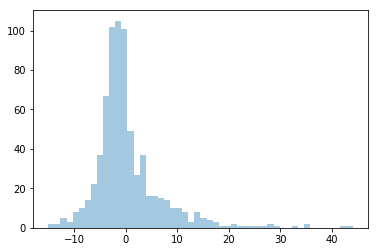

In [27]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))))
print(scipy.stats.normaltest(list(chain.from_iterable(o))))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


26.8779051711439

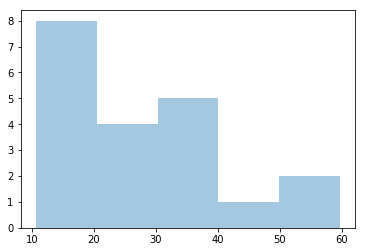

In [28]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-2.3284760719052016

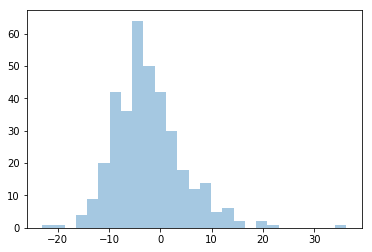

In [29]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.0
NormaltestResult(statistic=550.9549748986451, pvalue=2.2995735896961655e-120)


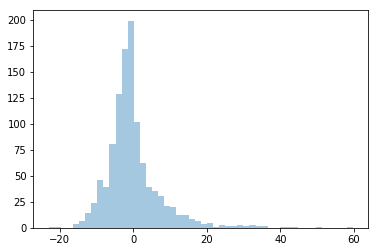

In [30]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print(np.mean(list(chain.from_iterable(m+o+r))))
print(scipy.stats.normaltest(list(chain.from_iterable(m+o+r))))

In [31]:
scipy.stats.normaltest(list(chain.from_iterable(m+o+r)))

NormaltestResult(statistic=550.9549748986451, pvalue=2.2995735896961655e-120)

# Woorden Balkenende 4

In [32]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text
5316,Thieme,PvdD,Mevrouw de voorzitter. Wij hebben te maken met...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter wij hebb te mak met een ...
5446,Marijnissen,SP,Mevrouw de voorzitter. Na de feestrede van de ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter na de feestred van de mi...
5447,Van Geel,CDA,Mevrouw de voorzitter. Ik dank de minister-pre...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ik dank de minister pres...
5448,Rutte,VVD,Mevrouw de voorzitter. Ook ik dank de regering...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ook ik dank de reger gra...
5449,Tichelaar,PvdA,Voorzitter. Ik dank de minister-president voor...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,voorzitter ik dank de minister president vor z...


In [33]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

CDA             1039
ChristenUnie     561
D66              518
GroenLinks       760
PVV              971
PvdA             903
PvdD             165
SGP              507
SP              1222
VVD             1041
Name: party, dtype: int64

In [34]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
dfb4['stemmed_text'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4['normal_text'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
5316,Thieme,PvdD,Mevrouw de voorzitter. Wij hebben te maken met...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter wij hebb te mak met een ...,mevrouw de voorzitter wij hebben te maken met ...
5446,Marijnissen,SP,Mevrouw de voorzitter. Na de feestrede van de ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter na de feestred van de mi...,mevrouw de voorzitter na de feestrede van de m...
5447,Van Geel,CDA,Mevrouw de voorzitter. Ik dank de minister-pre...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ik dank de minister pres...,mevrouw de voorzitter ik dank de minister pres...
5448,Rutte,VVD,Mevrouw de voorzitter. Ook ik dank de regering...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,mevrouw de voorzitter ook ik dank de reger gra...,mevrouw de voorzitter ook ik dank de regering ...
5449,Tichelaar,PvdA,Voorzitter. Ik dank de minister-president voor...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],Debat over de regeringsverklaring,voorzitter ik dank de minister president vor z...,voorzitter ik dank de minister president voor ...


['CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

['CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 25%|█████████████████████                                                               | 1/4 [00:38<01:54, 38.15s/it]

['CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 50%|██████████████████████████████████████████                                          | 2/4 [01:16<01:16, 38.20s/it]

['CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:08<00:42, 42.71s/it]

['CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:51<00:00, 42.78s/it]


              Precision  Recall  F1_score Accuracy  Documenten
CDA                0.46    0.68      0.54        -       210.4
ChristenUnie       0.61    0.45      0.51        -       118.8
D66                0.76    0.33      0.45        -       104.2
GroenLinks         0.58    0.52      0.55        -       152.4
PVV                0.66    0.66      0.66        -       192.4
PvdA               0.43    0.35      0.38        -       178.2
PvdD               0.75    0.43      0.55        -        34.4
SGP                0.75    0.83      0.79        -       103.2
SP                 0.49    0.64      0.55        -       240.2
VVD                0.53    0.40      0.44        -       203.8
Totaal             0.57    0.54      0.54     0.54      1538.0


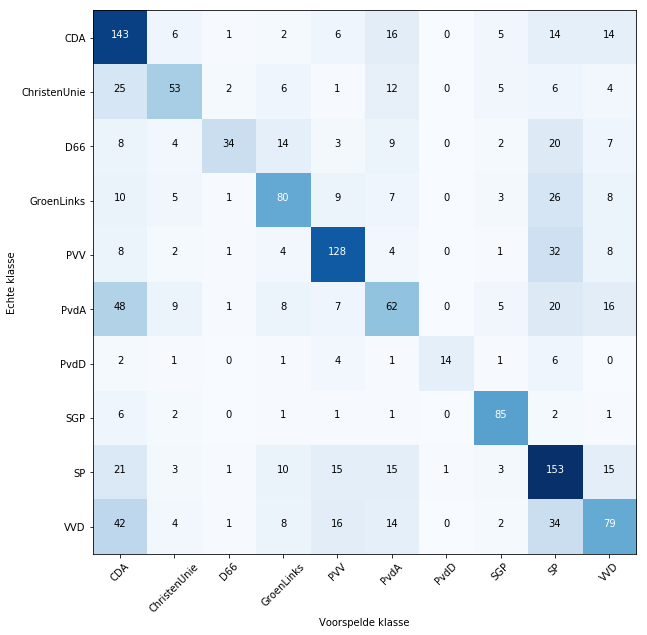

In [35]:
pipe = traintest('Scores.xlsx', dfb4)

In [36]:
mostimportantwords(pipe, countdfb4, 'WoordenBalkenende4')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,PARTIJ fractie,fractie van PARTIJ,premier,premier,burgers,wij,dieren,mijn fractie,mensen,PARTIJ
1,wij,de fractie van,ik hoop,PARTIJfractie,burger,vrouwen,bio industrie,beantwoording,zegt,PARTIJ fractie
2,fractie,de fractie,patiënt,fractie van PARTIJ,natuurlijk,belangrijk,veehouderij,wel,leraren,fractie
3,KAMERLID,fractie van,de premier,de fractie,immigratie,kinderen,de bio industrie,voorzitter ik wil,vandaar,onze fractie
4,dank,mijn fractie,arbeidsmarkt,de fractie van,de burgers,ben,de bio,natuurlijk,bureaucratie,je
5,wij hebben,verschillende,de patiënt,fractie van,onze,achtergrond,bio,bewindslieden,is,ondernemers
6,PARTIJ fractie heeft,over de,wanneer,mij,gewoon,antwoorden,de veehouderij,de voorzitter,leerlingen,markt
7,via,moment,de arbeidsmarkt,de premier,deze,of,dierenwelzijn,de bewindslieden,informatie,justitie
8,aangegeven,van PARTIJ,dadelijk,politieke,land,weten,natuur,dankzeggen,problemen,want
9,ons,over,hij,en,door,wij willen,industrie,dankzeggen voor,ruimtelijke,antwoorden


# Vergelijken

In [37]:
def traintest(file, data, save=False):
    pipe, stem = getbestpipe(file)
    train, test = data
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    report = classifaction_report_csv(test.party, predicted,False)
    print(report)
    accuracy = accuracy_score(test.party, predicted)
    print(accuracy)
    cnf_matrix = confusion_matrix(test.party, predicted)
    return pipe

In [38]:
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_text'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM') for t in tokenizer.tokenize(x)]))
df['normal_text'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERlIDNAAM').replace("yyyyy", 'PARTIJNAAM') for t in tokenizer.tokenize(x)]))
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


In [39]:
pipe = traintest('Scores.xlsx', (df[df.party != '50PLUS'],dfb4), save="RutToBal")

['CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']
              Precision  Recall  F1_score  Accuracy  Documenten
CDA                0.32    0.19      0.24       NaN        1039
ChristenUnie       0.32    0.25      0.28       NaN         561
D66                0.15    0.22      0.18       NaN         518
GroenLinks         0.24    0.03      0.06       NaN         760
PVV                0.53    0.54      0.54       NaN         971
PvdA               0.27    0.30      0.28       NaN         903
PvdD               0.60    0.50      0.55       NaN         165
SGP                0.41    0.63      0.50       NaN         507
SP                 0.37    0.62      0.46       NaN        1222
VVD                0.18    0.15      0.17       NaN        1041
Totaal             0.32    0.34      0.31  0.337063        7687
0.3370625731754911


In [ ]:
pipe = traintest('Scores.xlsx', (dfb4,df[df.party != '50PLUS']), save="BalToRut")

In [ ]:
woordenBalk = df = pd.read_excel('WoordenBalkenende4.xlsx', index_col=0)

# Links / Rechts vergelijken

In [ ]:
# df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})
# pipe, predicted = traintest('Scores.xlsx', datasplitter(df.dropna(), 0.8))

In [ ]:
# pipe, _ = getbestpipe('Scores.xlsx')
# df_train = df.dropna().sample(frac=0.8)
# df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
# df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
# pipe.fit(df_train.withoutnames, df_train.Kieskompas)
# predicted = pipe.predict(df_test.withoutnames)
# print(classification_report(df_test.Kieskompas, predicted))

# Taalgebruik van sprekers

In [42]:
def traintest3(pipe, stem, data, save=False):
    trainsprekers, testsprekers = train_test_split(data.surname.unique(), test_size=0.2)
    train = data[data['surname'].isin(trainsprekers)]
    test = data[data['surname'].isin(testsprekers)]
     
    if stem:
        pipe.fit(train.stemmed_text, train.party)
        predicted = pipe.predict(test.stemmed_text)
    else:
        pipe.fit(train.normal_text,train.party)
        predicted = pipe.predict(test.normal_text)
    report = classifaction_report_csv(test.party, predicted,False)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    return pipe, cnf_matrix, report, accuracy
    

def traintest(file, data, save=False, params=None):
    n = 5
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    pipe, cnf_matrix, report, accuracy = traintest3(base_pipe, stem, data, save=False)
    for x in tqdm(range(n-1)):
        _, cnf_matrix2, report2, accuracy2 = traintest3(base_pipe, stem, data, save=False)
        cnf_matrix = np.add(cnf_matrix,cnf_matrix2)
        report = report.add(report2, fill_value=0)
        accuracy += accuracy2
    accuracy /=n
    cnf_matrix = np.divide(cnf_matrix,n)
    report /=n
     
    print(report)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipe

In [ ]:
pipe = traintest('Scores.xlsx', df ,save="taalgebruik")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 11%|█████████▎                                                                          | 1/9 [01:22<10:58, 82.31s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 22%|██████████████████▋                                                                 | 2/9 [02:42<09:27, 81.10s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 33%|████████████████████████████                                                        | 3/9 [04:04<08:08, 81.47s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 44%|█████████████████████████████████████▎                                              | 4/9 [05:30<06:52, 82.54s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 56%|██████████████████████████████████████████████▋                                     | 5/9 [06:52<05:29, 82.49s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 67%|████████████████████████████████████████████████████████                            | 6/9 [08:11<04:05, 81.91s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PVV', 'PvdA', 'PvdD', 'SGP', 'SP', 'VVD', 'avg/total']


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [09:28<02:42, 81.18s/it]

In [ ]:
mostimportantwords(pipe, countdf, 'taalgebruik')

# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.xlsx
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/WoordenBalkenende41.tex
!git add Verslag/Tables/WoordenBalkenende42.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/Correlation.png
!git add Verslag/Tables/confusionmatrix.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Verslag/Tables/lengthtextslog.png
!git add Verslag/Tables/lengthtexts.png
!git add Verslag/Tables/Totaal.png
!git add Verslag/Tables/Mix.png
!git add Verslag/Tables/withoutnames.tex
!git add Verslag/Tables/taalgebruik.tex
!git add Verslag/Tables/onlynames.tex
!git add Verslag/Tables/Regering.png
!git add Verslag/Tables/Oppositie.png
!git add Models.xlsx
!git add Verslag/Tables/confusionmatrix.png
!git commit -m Update
!git push